In [ ]:
!pip install PyDrive
!pip install gensim
!pip install pyldavis
!pip install spacy
!python -m spacy download en_core_web_sm
!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [1]:
import os
import nltk
from nltk import FreqDist
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kobei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import json
import re
import gzip
import spacy

import gensim
from gensim import corpora

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Health_and_Personal_Care_5.json.gz')

In [4]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,ALC5GH8CAMAI7,159985130X,AnnN,"[1, 1]","This is a great little gadget to have around. We've already used it to look for splinters and a few other uses. The light is great. It's a handy size. However, I do wish I'd bought one with a ...",5.0,Handy little gadget,1294185600,"01 5, 2011"
1,AHKSURW85PJUE,159985130X,"AZ buyer ""AZ buyer""","[1, 1]",I would recommend this for a travel magnifier for the occasional reading.I had read on another review about a magnifier having a problem with the light coming on. I did find that this one appeared...,4.0,Small & may need to encourage battery,1329523200,"02 18, 2012"
2,A38RMU1Y5TDP9,159985130X,"Bob Tobias ""Robert Tobias""","[75, 77]",What I liked was the quality of the lens and the built in light. Then lens had no discernable distortion anywhere. It magnified everything evenly without the ripples and distortion that I've se...,4.0,Very good but not great,1275955200,"06 8, 2010"
3,A1XZUG7DFXXOS4,159985130X,Cat lover,"[56, 60]","Love the Great point light pocket magnifier! works great, especially if you forget your glasses and can't read the menu when you are out for dinner.... the light is a bonus in a dark restaurant, ...",4.0,great addition to your purse,1202428800,"02 8, 2008"
4,A1MS3M7M7AM13X,159985130X,Cricketoes,"[1, 1]","This is very nice. You pull out on the magnifier when you want the light to come on, then slide it back in. I would recommend buying this if you need something with a light that you can easily put...",5.0,Very nice and convenient.,1313452800,"08 16, 2011"


In [5]:
def freq_words(x, terms = 20):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

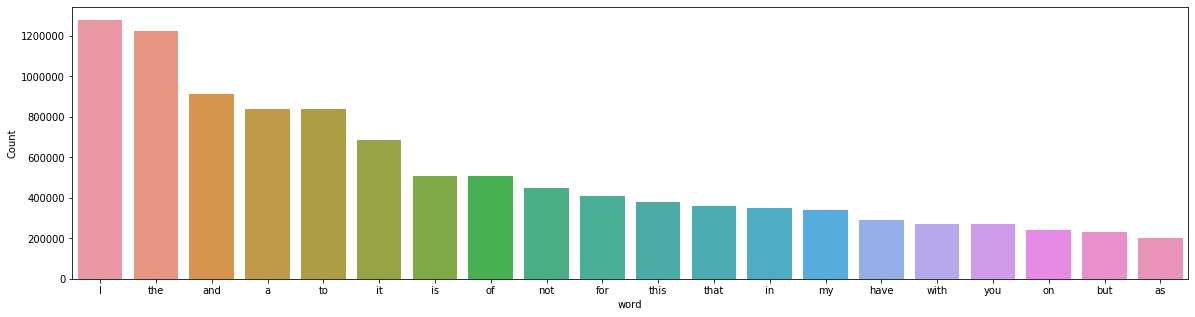

In [6]:
# replace "n't" with " not"
df['reviewText'] = df['reviewText'].str.replace("n\'t", " not")

# remove unwanted characters, numbers and symbols
df['reviewText'] = df['reviewText'].str.replace("[^a-zA-Z#]", " ")

freq_words(df['reviewText'])

In [7]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [8]:
# function to remove stopwords
def remove_stopwords(rev):
  rev_new = " ".join([i for i in rev if i not in stop_words])
  return rev_new

In [9]:
# remove short words (length < 4)
df['reviewText'] = df['reviewText'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# remove stopwords from the text
reviews = [remove_stopwords(r.split()) for r in df['reviewText']]

# make entire text lowercase
reviews = [r.lower() for r in reviews]

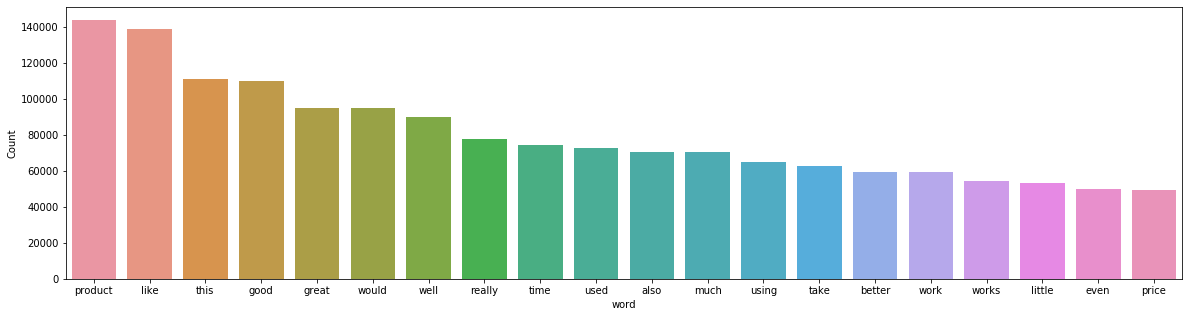

In [10]:
freq_words(reviews, 20)

In [11]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [12]:
def lemmatization(texts, tags=['NOUN', 'ADJ']):
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [13]:
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())
print(tokenized_reviews[1])

['would', 'recommend', 'travel', 'magnifier', 'occasional', 'reading', 'read', 'another', 'review', 'magnifier', 'problem', 'light', 'coming', 'find', 'appeared', 'opening', 'shutting', 'viewer', 'turn', 'light', 'light', 'began', 'come', 'after', 'several', 'times', 'light', 'appears', 'coming', 'time', 'small', 'taking', 'someplace', 'reading', 'things', 'like', 'menu', 'dark', 'corner', 'restaurant', 'great']


In [14]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1])

['magnifi', 'occasional', 'reading', 'review', 'magnifi', 'problem', 'light', 'view', 'turn', 'light', 'light', 'several', 'time', 'light', 'time', 'small', 'someplace', 'thing', 'menu', 'dark', 'corner', 'restaurant', 'great']


In [15]:
set(tokenized_reviews[1]) - set(reviews_2[1])

{'after',
 'another',
 'appeared',
 'appears',
 'began',
 'come',
 'coming',
 'find',
 'like',
 'magnifier',
 'opening',
 'read',
 'recommend',
 'shutting',
 'taking',
 'things',
 'times',
 'travel',
 'viewer',
 'would'}

In [16]:
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))
    
df['reviews'] = reviews_3

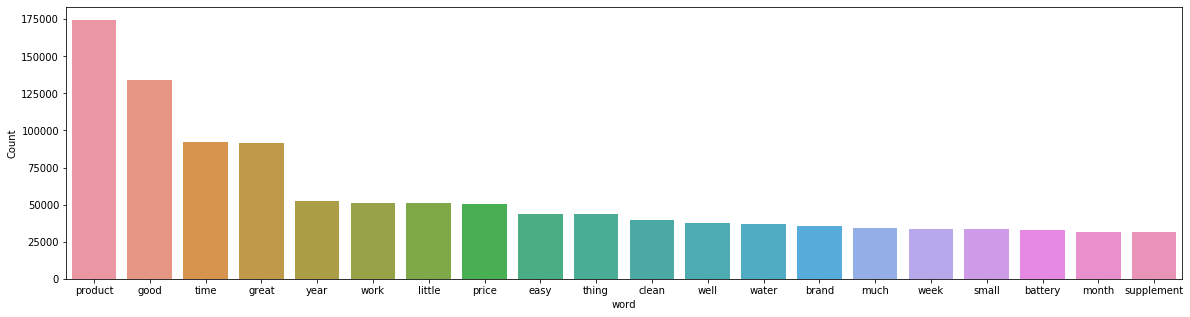

In [17]:
freq_words(df['reviews'], 20)

In [18]:
# Create the term dictionary of our corpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(reviews_2)

In [19]:
# Convert list of reviews (reviews_2) into a Document Term Matrix using the dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

In [20]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

In [21]:
# Build LDA model
lda_model = LDA(corpus=doc_term_matrix,
                id2word=dictionary,
                num_topics=7, 
                random_state=100,
                chunksize=1000,
                passes=50)

In [22]:
lda_model.print_topics()

[(0,
  '0.042*"product" + 0.033*"pill" + 0.028*"energy" + 0.023*"vitamin" + 0.022*"effect" + 0.013*"sleep" + 0.012*"good" + 0.012*"natural" + 0.011*"side" + 0.010*"capsule"'),
 (1,
  '0.037*"clean" + 0.018*"water" + 0.018*"tooth" + 0.016*"brush" + 0.014*"small" + 0.012*"great" + 0.012*"easy" + 0.010*"product" + 0.010*"little" + 0.010*"white"'),
 (2,
  '0.048*"time" + 0.025*"week" + 0.020*"product" + 0.019*"work" + 0.018*"first" + 0.018*"review" + 0.016*"result" + 0.015*"thing" + 0.015*"day" + 0.014*"ingredient"'),
 (3,
  '0.029*"price" + 0.026*"good" + 0.024*"battery" + 0.020*"product" + 0.020*"great" + 0.013*"brand" + 0.013*"quality" + 0.012*"easy" + 0.012*"unit" + 0.010*"device"'),
 (4,
  '0.055*"product" + 0.037*"supplement" + 0.018*"skin" + 0.017*"good" + 0.015*"great" + 0.015*"pain" + 0.014*"deodorant" + 0.011*"body" + 0.010*"smell" + 0.009*"health"'),
 (5,
  '0.037*"scent" + 0.035*"razor" + 0.034*"hair" + 0.023*"shave" + 0.020*"blade" + 0.017*"good" + 0.017*"head" + 0.014*"trimme

In [23]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

C:\Users\kobei\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.045504  0.035412       1        1  17.401510
2     -0.046115 -0.268731       2        1  17.190695
3     -0.071220 -0.027880       3        1  16.487431
1     -0.133961  0.189734       4        1  14.014909
0      0.221839 -0.138673       5        1  13.648600
5     -0.230453  0.010934       6        1  10.995737
6      0.214406  0.199203       7        1  10.261118, topic_info=     Category           Freq        Term          Total  loglift  logprob
269   Default   59280.000000      weight   59280.000000  30.0000  30.0000
1144  Default   52303.000000  supplement   52303.000000  29.0000  29.0000
24    Default   87293.000000        time   87293.000000  28.0000  28.0000
352   Default   46521.000000       clean   46521.000000  27.0000  27.0000
2353  Default   32915.000000       scent   32915.000000  26.0000  26.0000
234   Default   35658.000000        pill   35658.000000  25.0000  25.0000
100   Default   38742.000000       price   38742.000000  24.0000  24.0000
355   Default   30634.000000       razor   30634.000000  23.0000  23.0000
400   Default   30002.000000        hair   30002.000000  22.0000  22.0000
629   Default   30740.000000      energy   30740.000000  21.0000  21.0000
90    Default   32354.000000     battery   32354.000000  20.0000  20.0000
178   Default  214259.000000     product  214259.000000  19.0000  19.0000
4078  Default   25366.000000     vitamin   25366.000000  18.0000  18.0000
158   Default   45264.000000        week   45264.000000  17.0000  17.0000
5123  Default   21836.000000       pound   21836.000000  16.0000  16.0000
1272  Default   23831.000000        loss   23831.000000  15.0000  15.0000
1379  Default   23600.000000      effect   23600.000000  14.0000  14.0000
412   Default   36088.000000        skin   36088.000000  13.0000  13.0000
366   Default   19928.000000       shave   19928.000000  12.0000  12.0000
3199  Default   18632.000000       taste   18632.000000  11.0000  11.0000
42    Default   28989.000000       first   28989.000000  10.0000  10.0000
1367  Default   19929.000000       tooth   19929.000000   9.0000   9.0000
416   Default   32542.000000       water   32542.000000   8.0000   8.0000
1898  Default   16847.000000        food   16847.000000   7.0000   7.0000
359   Default   17266.000000       blade   17266.000000   6.0000   6.0000
19    Default   31516.000000      review   31516.000000   5.0000   5.0000
1163  Default   20907.000000        pain   20907.000000   4.0000   4.0000
1107  Default   32269.000000      result   32269.000000   3.0000   3.0000
373   Default   21601.000000        head   21601.000000   2.0000   2.0000
44    Default  119671.000000        good  119671.000000   1.0000   1.0000
...       ...            ...         ...            ...      ...      ...
3670   Topic7    2933.592529   chocolate    2934.337402   2.2766  -5.6379
3693   Topic7    2742.516602  artificial    2743.263428   2.2765  -5.7052
5147   Topic7    2558.210449      hunger    2558.955811   2.2765  -5.7748
3498   Topic7    2541.743408     texture    2542.490967   2.2765  -5.7812
2680   Topic7    2529.968750       blend    2530.715576   2.2765  -5.7859
2048   Topic7    2394.321045        tank    2395.073486   2.2765  -5.8410
5192   Topic7    2319.181885   nutrition    2319.928467   2.2765  -5.8729
5135   Topic7    2155.107666         bar    2155.853516   2.2765  -5.9462
2103   Topic7    2138.458496       shake    2139.203857   2.2765  -5.9540
8101   Topic7    2105.953369         pod    2106.709473   2.2764  -5.9693
6100   Topic7    1975.084473   raspberry    1975.829956   2.2764  -6.0335
4931   Topic7    1964.467896        gain    1965.215698   2.2764  -6.0389
269    Topic7   59004.617188      weight   59280.636719   2.2721  -2.6365
1272   Topic7   21470.449219        loss   23831.107422   2.1725  -3.6474
696    Topic7    8765.093750       green    9601.626953   2.1857  -